## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from pathlib import Path
# another way of ignoring warnings
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
path = Path().cwd()
data_file = "Data/ClevelandHeartData.csv"

T = pd.read_csv(data_file, sep=';')
X = T.loc[:, T.columns != 'Diagnosis']
y = np.array(T.loc[:, T.columns == 'Diagnosis'])

# Some of the data is written in a European format, that doesn't work in python
X['Oldpeak'] = pd.Series(X['Oldpeak']).str.replace(',', '.')
# Decision trees in python don't handle NaN values in the same way as in matlab
# This model does not support missing values
# we replace every empty value with the column's mode since we have categorical 
for column in X.columns:
    X[column].fillna(X[column].mode()[0], inplace=True)


Xlabel = np.array(T.columns[:-1])
Nobs = len(T)
Nfeature = len(Xlabel)
print(f'Number of observations: {Nobs}.')
print(f'Number of features: {Nfeature}.')
print(f'Labels of features: {Xlabel}')
print(T)

Number of observations: 303.
Number of features: 13.
Labels of features: ['Age' 'Sex' 'Cp' 'Trestbps' 'Chol' 'Fbs' 'RestECG' 'Thalach' 'Exang'
 'Oldpeak' 'Slope' 'Ca' 'Thal']
     Age  Sex  Cp  Trestbps  Chol  Fbs  RestECG  Thalach  Exang Oldpeak  \
0     63    1   1       145   233    1        2      150      0     2,3   
1     67    1   4       160   286    0        2      108      1     1,5   
2     67    1   4       120   229    0        2      129      1     2,6   
3     37    1   3       130   250    0        0      187      0     3,5   
4     41    0   2       130   204    0        2      172      0     1,4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...     ...   
298   45    1   1       110   264    0        0      132      0     1,2   
299   68    1   4       144   193    1        0      141      0     3,4   
300   57    1   4       130   131    0        0      115      1     1,2   
301   57    0   2       130   236    0        2      174      0       0   


### 2. Matlab and R have functions for building, pruning, evaluating and viewing classification and regression trees. We are going touse them to diagnose heart problems based on a set of 13 clinical variables from 303 patients and healthy controls. The data is in the file ClevelandHeartData.csv. The first 13 columns are different features and the 14th column is an indicator for heart problem/healthy. You can read more about the data in ClevelandHeartDataDescription.txt.

> a) Read the help files for the tree methods in your preferred language to familiarize yourself with the possibilities.

Done

Read about options in the DecisionTreeClassifier at http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


> b) Build a large tree with the minimum number of observations (minLeaf ) in at leaf
set to 1 and view the tree.

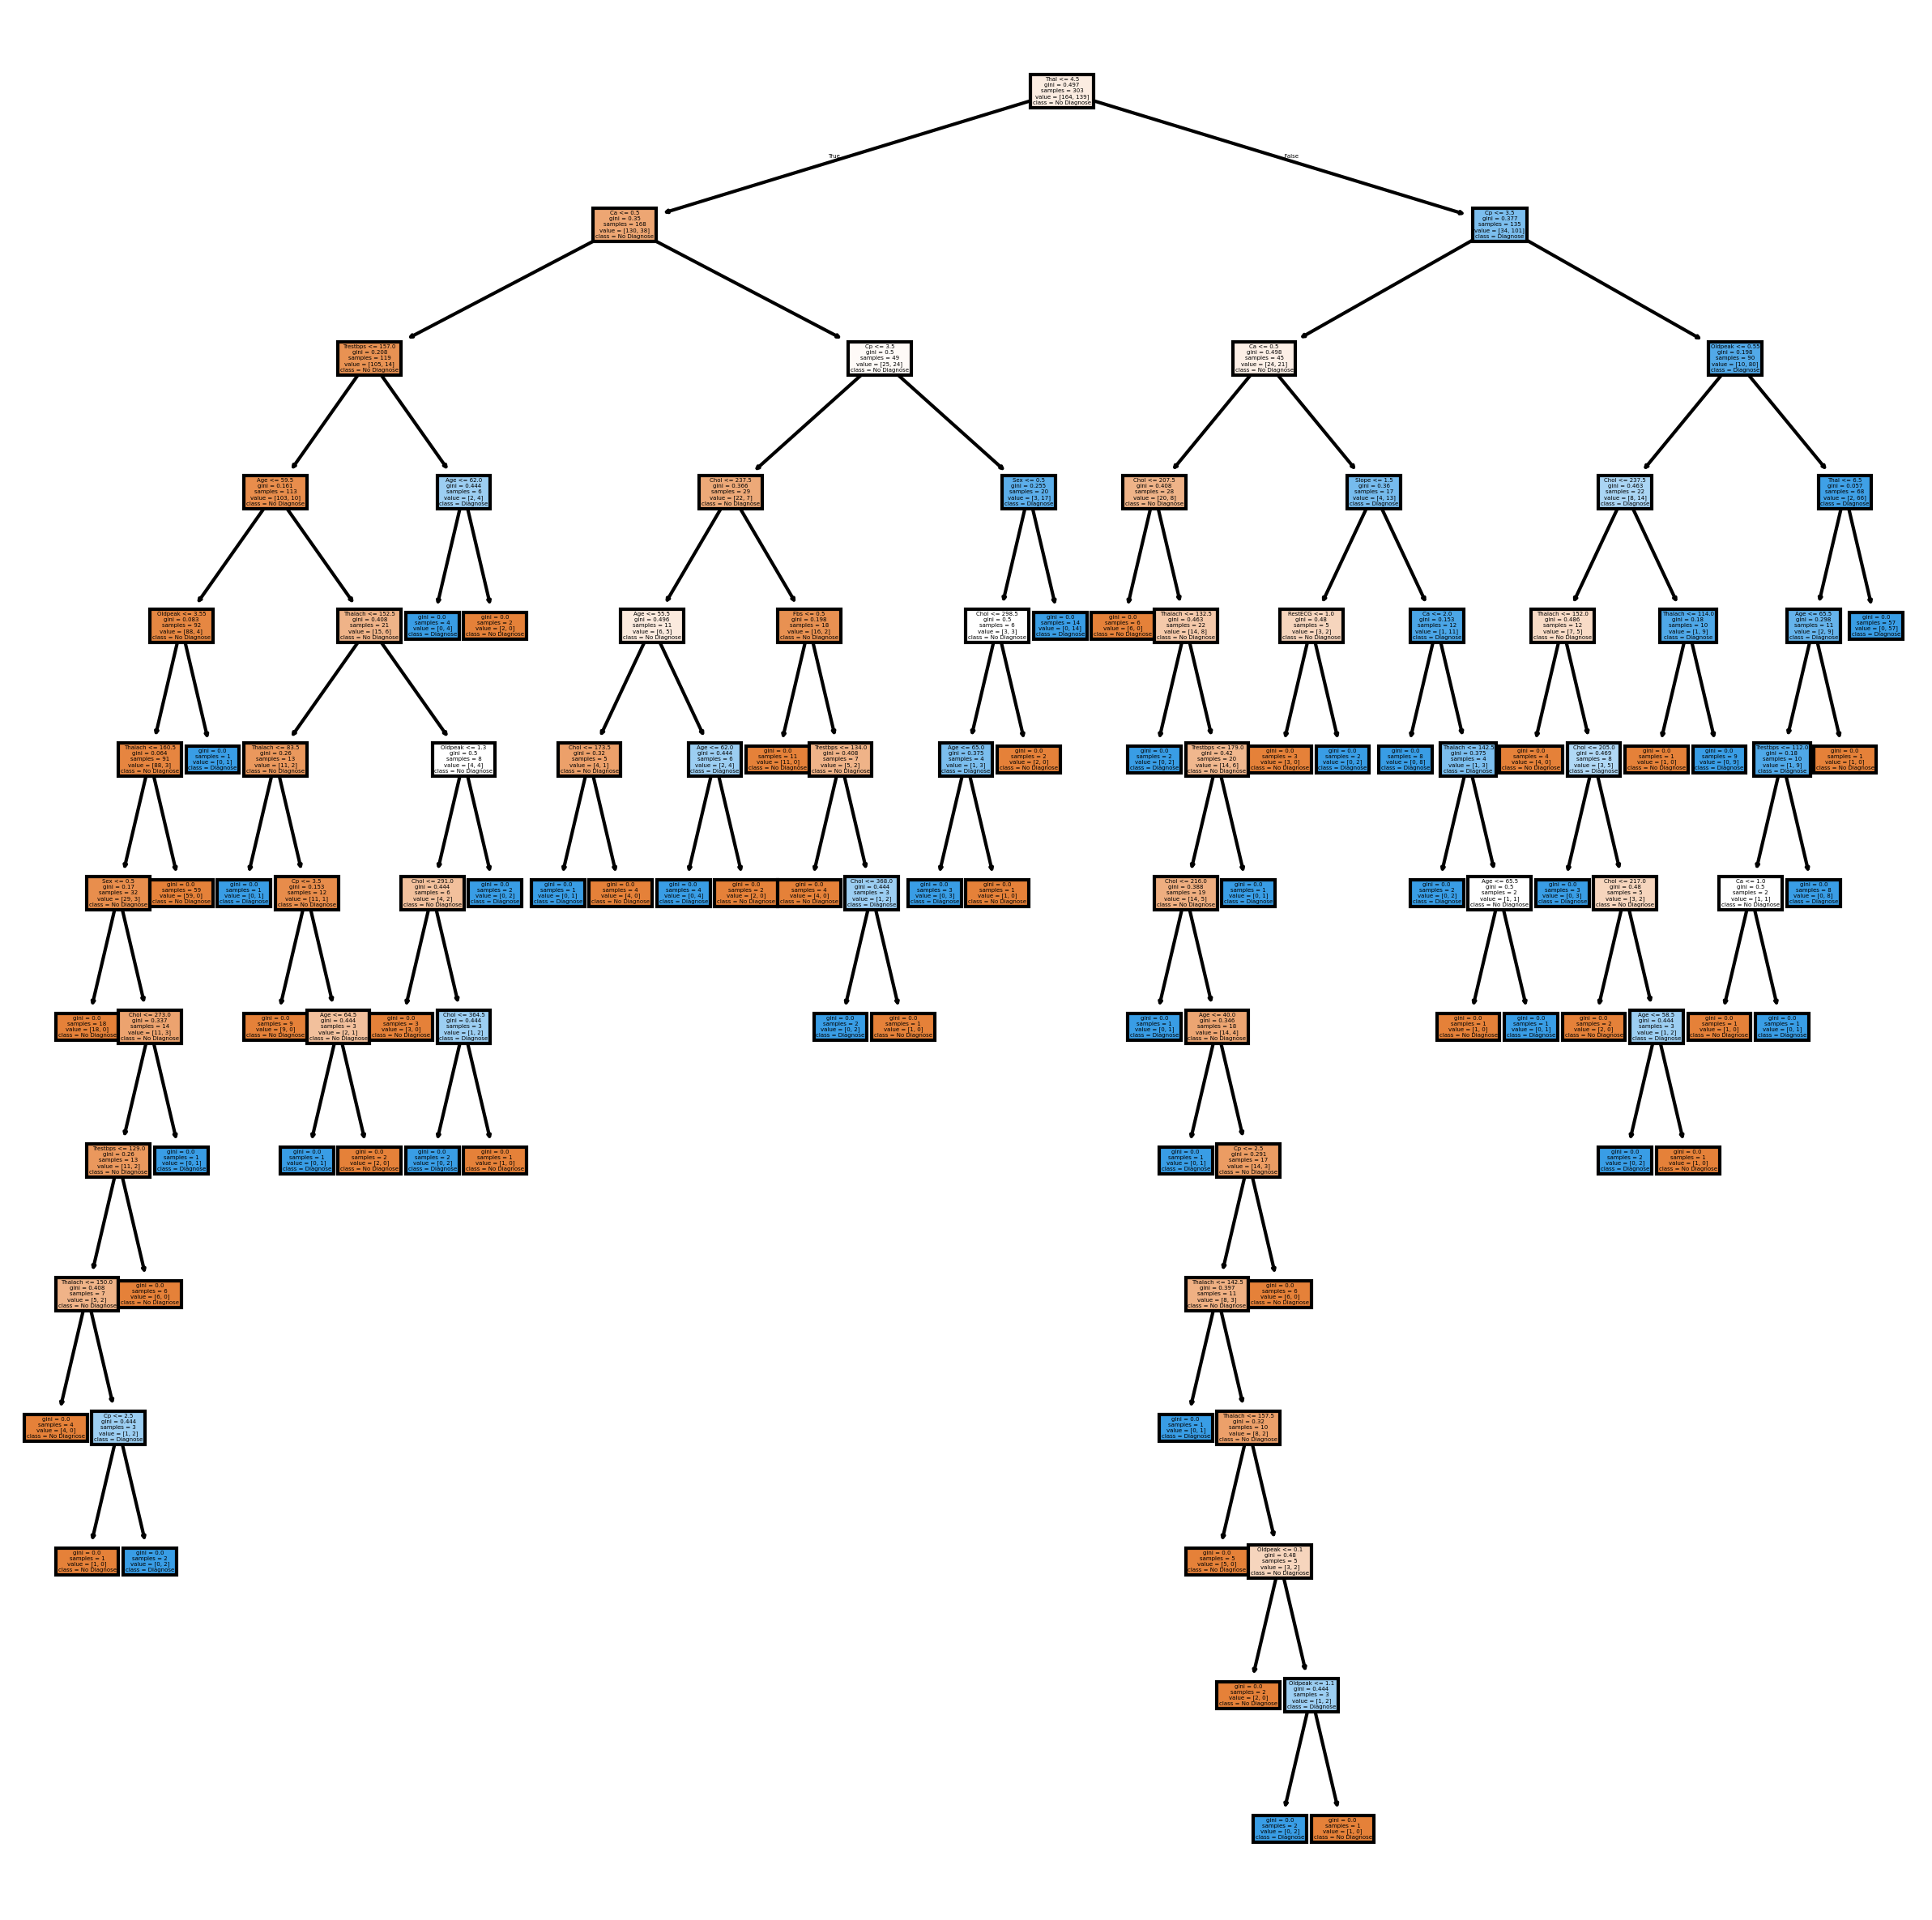

In [3]:
# Build and view a large tree
dtree= DecisionTreeClassifier(min_samples_leaf=1)
dtree.fit(X, y)



fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(dtree,
               feature_names = Xlabel,
               class_names = ['No Diagnose','Diagnose'],
               filled = True);

#A little description of the information at each plotted node
#1. row: The condition
#2. row: The impurity score of the node
#3. row: The number of observations at this node
#4. row: The number of samples for each class at this node
#5. row: The class by majority voting

> c) Choose optimal tree size by tuning the parameter MinLeaf value using cross
validation.

best estimator: DecisionTreeClassifier(min_samples_leaf=10)


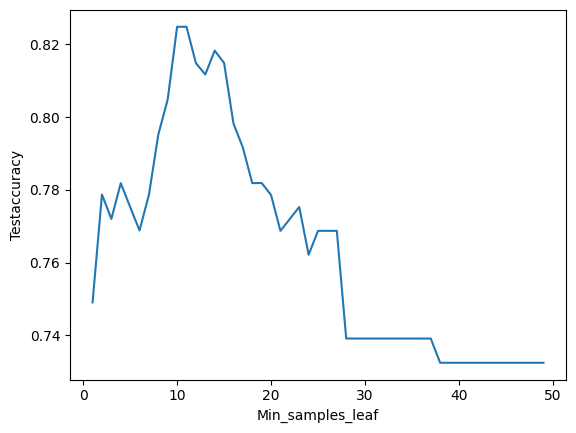

In [4]:
# use cross validation to tune the hyper parameter for nim_sample_leaf
# use sklearns GridSearchCV
dtree = DecisionTreeClassifier()
cv_grid = GridSearchCV(estimator=dtree, param_grid={'min_samples_leaf': range(1,50)}, cv=5)

# Fit the grid search model
cv_grid.fit(X, y)

#plot the results
plt.plot(range(1,50),cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Min_samples_leaf')
plt.ylabel('Testaccuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

In [8]:
# One standard error rule
meanError = list(cv_grid.cv_results_['mean_test_score'])
stdError = cv_grid.cv_results_['std_test_score']
# this is the index of the smallest error
minError = meanError.index(min(meanError))

# the model picks model with highest accuracy and because of that we use max
maxAcc = meanError.index(max(meanError))
 # model does accuracy and not error so we flip shit!
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if (len(J) > 0):
    j = int(J[-1::])
else:
    j = minError

min_sample_leaf_opt = j+1
print (f'One standard error rule gives min_samples_leaf: {min_sample_leaf_opt}') # +1 because zero indexed

One standard error rule gives min_samples_leaf: 17


> d) View the optimal tree and try to interpret it such that it makes sense for a doctor.

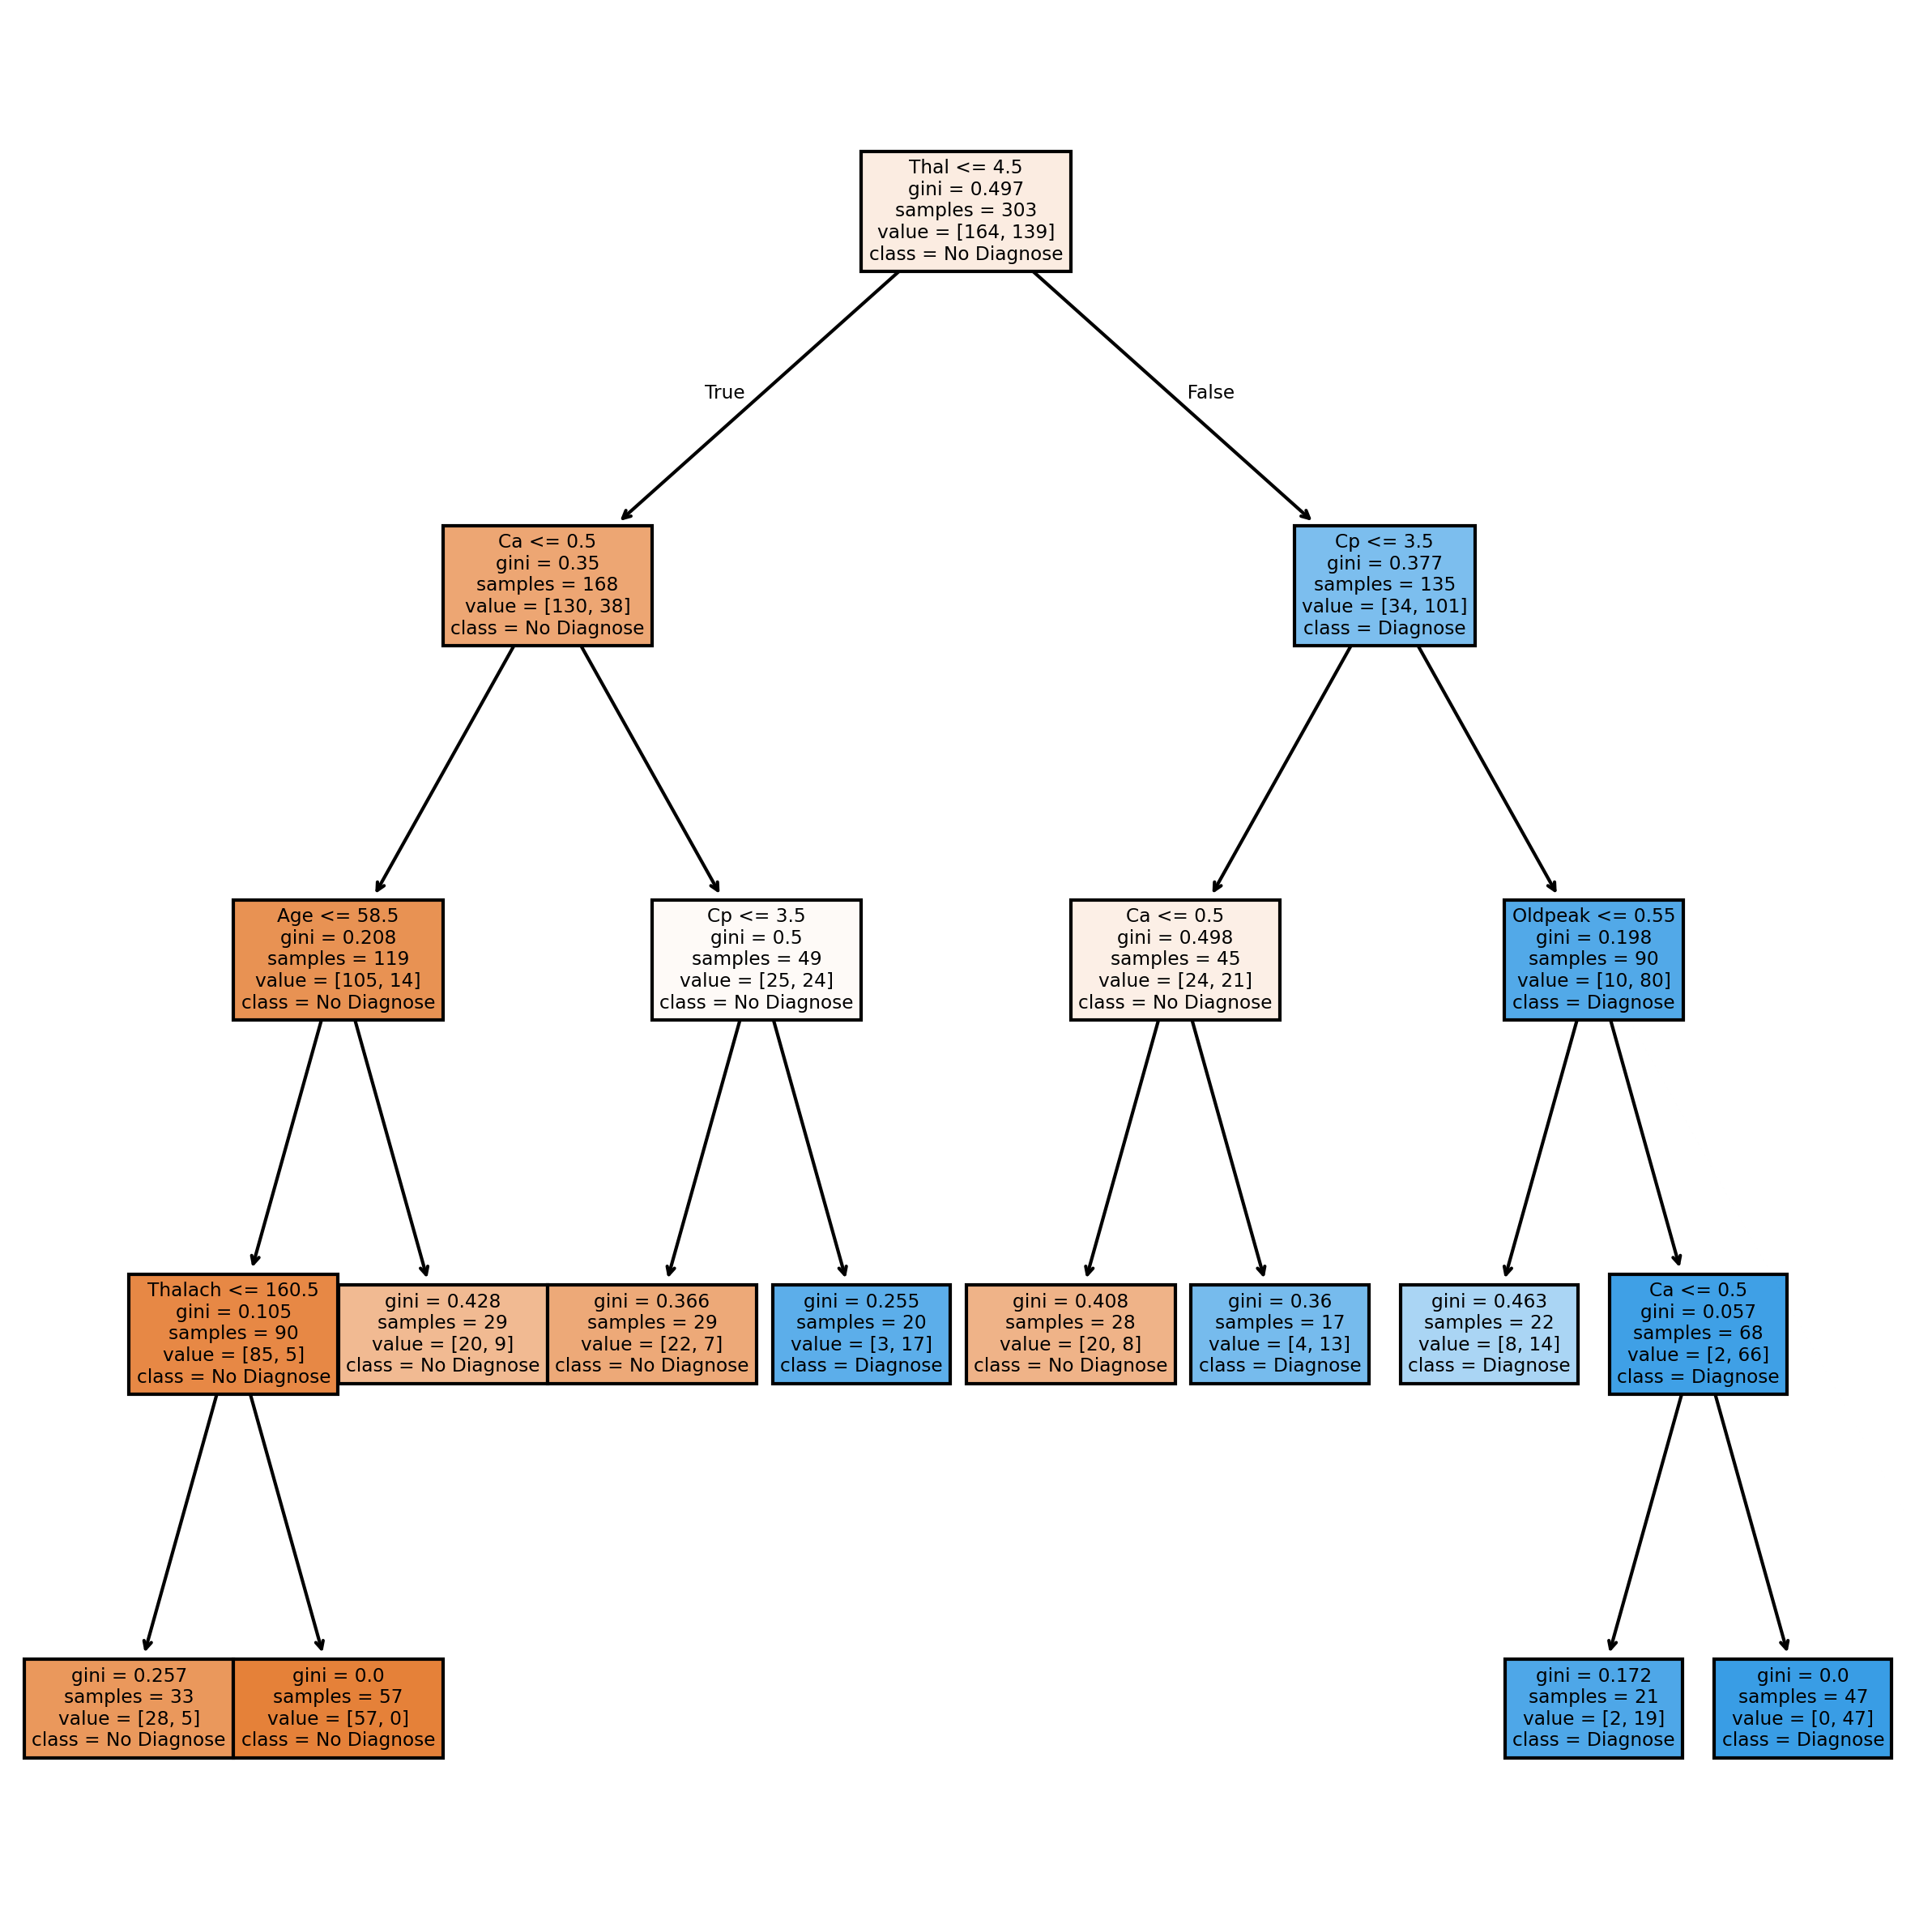

In [11]:
# Build a tree based on best nim_sample_leaf
dtree = DecisionTreeClassifier(min_samples_leaf=min_sample_leaf_opt)
dtree.fit(X, y)


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(dtree,
               feature_names = Xlabel,
               class_names = ['No Diagnose','Diagnose'],
               filled = True);

## If you have scikit-learn 0.22 <= then you can also find the tree size through cost complexity pruning of the best estimator

In [ ]:
# here we prune the tree instead of using the one std error because the tree becomes too small
# use cross validation to minimize cost complexity pruning
dtree = DecisionTreeClassifier()

# Complexity parameter used for Minimal Cost-Complexity Pruning. 
# The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
ccp_alphas = np.linspace(0, 1, 50)

param_grid = {
    'ccp_alpha': ccp_alphas,
    'criterion': ['gini', 'entropy']
    
}
cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# Fit the grid search model
cv_grid.fit(X, y)

print(f'best estimator: {cv_grid.best_estimator_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best estimator: DecisionTreeClassifier(ccp_alpha=np.float64(0.02040816326530612))


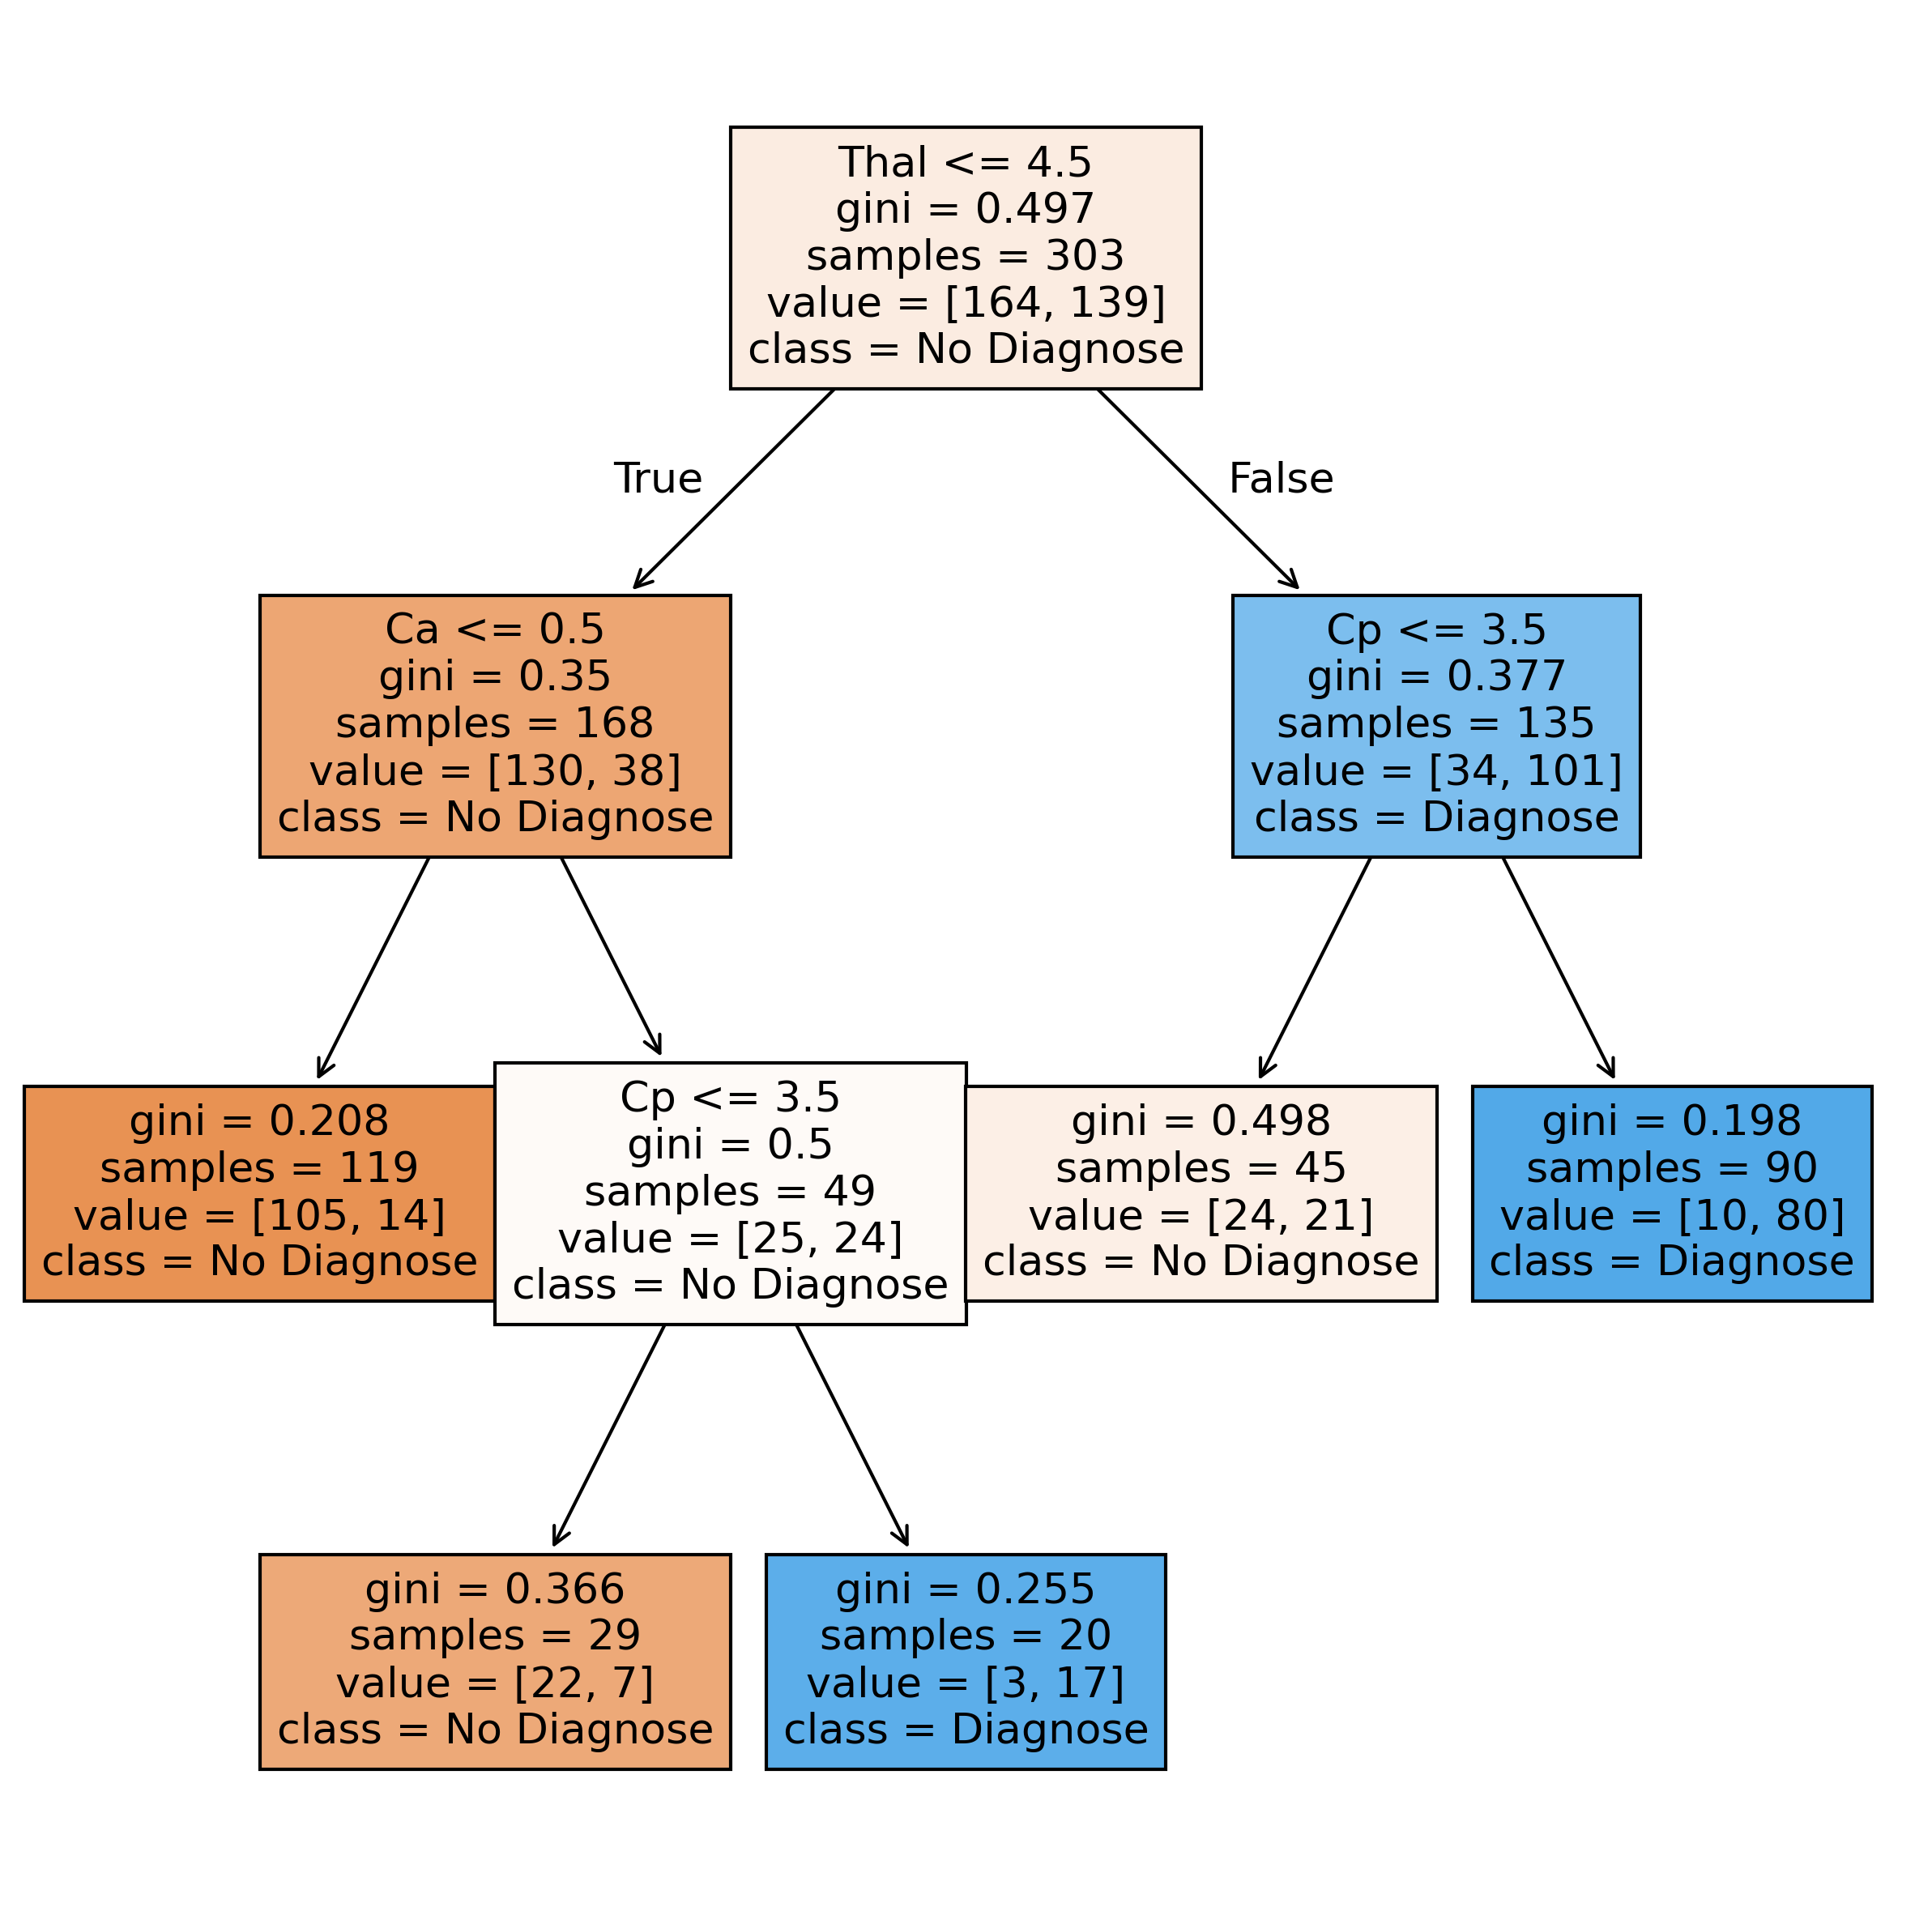

In [14]:
# Build a tree based on best pruning params
dtree= DecisionTreeClassifier(ccp_alpha=cv_grid.best_estimator_.ccp_alpha, criterion='gini')
dtree.fit(X, y)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(dtree,
               feature_names = Xlabel,
               class_names = ['No Diagnose','Diagnose'],
               filled = True);